### Fine-tuned model VS original model
We can load both a fine-tuned checkpoint and the original one to compare them and see if there's any progress.

In [1]:
from segment_anything import sam_model_registry, SamPredictor
import torch
import cv2

model_type = 'vit_b'
device = 'cuda:0'

checkpoint_orig = '../scripts/sam_vit_b_01ec64.pth'
checkpoint_tuned = '../scripts/sam_vit_b_01ec64_epoch_5.pth'

sam_model_orig = sam_model_registry[model_type](checkpoint=checkpoint_orig)
sam_model_orig.to(device)
sam_model_tuned = sam_model_registry[model_type](checkpoint=checkpoint_tuned)
# sam_model_tuned = sam_model_registry[model_type](checkpoint=checkpoint_orig)
# sd = torch.load(checkpoint_tuned, map_location=torch.device('cpu'))
# sam_model_tuned.load_state_dict(sd)
# sam_model_tuned.to(device)

In [2]:
predictor_orig = SamPredictor(sam_model_orig)
predictor_tuned = SamPredictor(sam_model_tuned)

In [3]:
# Last subject was held out for testing
subj = 'sub-nyuMouse36'
test_sample = 'sample-0007'

import sys
sys.path.append('../scripts')
import bids_utils
from pathlib import Path
import pandas as pd

def get_sample_bboxes(subject, sample, maps_path):
    prompts_fname = maps_path / subject / 'micr' / f'{subject}_{sample}_prompts.csv'
    prompts_df = pd.read_csv(prompts_fname)
    return prompts_df[['bbox_min_x', 'bbox_min_y', 'bbox_max_x', 'bbox_max_y']]

def get_myelin_bbox(bbox_df, axon_id):
    return np.array(bbox_df.iloc[axon_id])

def get_myelin_map(subject, sample, maps_path):
    map_fname = maps_path / subject / 'micr' / f'{subject}_{sample}_myelinmap.png'
    return cv2.imread(str(map_fname))
    
def get_myelin_mask(myelin_map, axon_id):
    return 255 * (myelin_map == axon_id + 1)

datapath = Path('../data_axondeepseg_tem/')
derivatives_path = Path('../scripts/derivatives')
embeddings_path = derivatives_path / 'embeddings'
maps_path = derivatives_path / 'maps'

data_dict = bids_utils.index_bids_dataset(datapath)

image = cv2.imread('training/sub-nyuMouse36_sample-0007_TEM.png')
bboxes = get_sample_bboxes(subj, test_sample, maps_path)
myelin_map = get_myelin_map(subj, test_sample, maps_path)

predictor_tuned.set_image(image)
predictor_orig.set_image(image)

0 samples collected.


In [4]:
def show_mask(mask, ax):
    color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

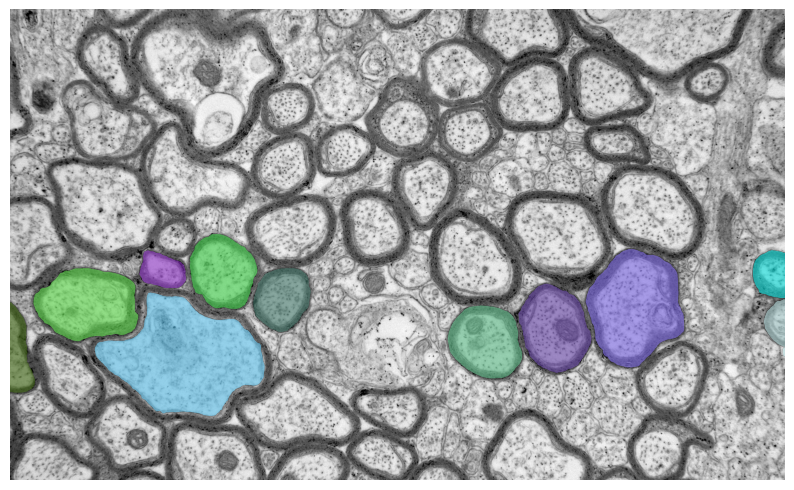

In [5]:
# ORIGINAL PREDICTIONS
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(image)

for axon_id in range(len(bboxes)):
    if axon_id < 30 or axon_id > 40:
        continue
    # get mask and bbox prompt
    prompt = get_myelin_bbox(bboxes, axon_id)
    
    mask_orig, _, _ = predictor_orig.predict(
        point_coords=None,
        box=prompt,
        multimask_output=False,
    )
    show_mask(mask_orig.squeeze(), plt.gca())
plt.axis('off')
plt.show()
plt.close()

showing 30
showing 31
showing 32
showing 33
showing 34
showing 35
showing 36
showing 37
showing 38
showing 39
showing 40


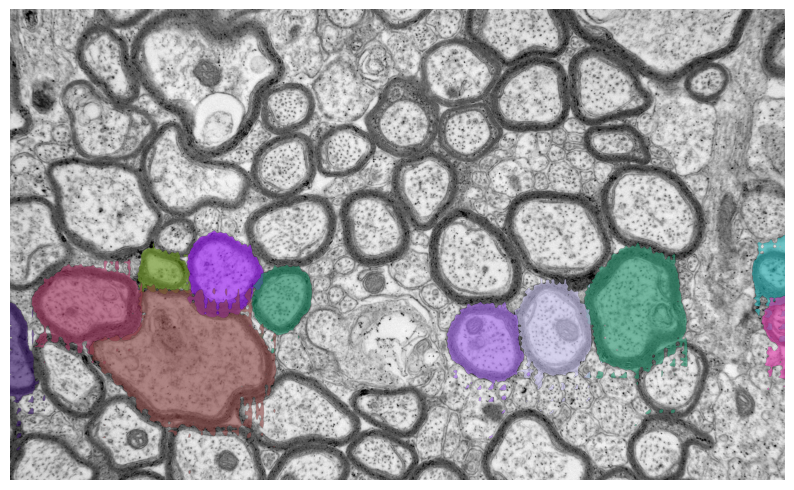

In [6]:
# PREDICTIONS AFTER 5 EPOCHS
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 10))
plt.imshow(image)

for axon_id in range(len(bboxes)):
    if axon_id < 30 or axon_id > 40:
        continue
    # get mask and bbox prompt
    prompt = get_myelin_bbox(bboxes, axon_id)
    
    mask_tuned, _, _ = predictor_tuned.predict(
        point_coords=None,
        box=prompt,
        multimask_output=False,
    )
    show_mask(mask_tuned.squeeze(), plt.gca())
    print(f'showing {axon_id}')
plt.axis('off')
plt.show()
plt.close()